In [1]:
import pandas as pd
import datetime
import fastf1
import matplotlib.patches as patches
import matplotlib.pyplot as plt
session = fastf1.get_session(2022,1,'FP2')
session.load()

api         WARNING 	

NO CACHE! Api caching has not been enabled! 
	It is highly recommended to enable this feature for much faster data loading!
	Use `fastf1.Cache.enable_cache('path/to/cache/')`

core           INFO 	Loading data for Bahrain Grand Prix - Practice 2 [v2.3.0]
api            INFO 	Fetching driver list...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Fetching timing app data...
core           INFO 	Processing timing data...
api            INFO 	Fetching session status data...
api            INFO 	Fetching track status data...
api            INFO 	Fetching car data...
api            INFO 	Parsing car data...
api            INFO 	Fetching position data...
api            INFO 	Parsing position data...
api            INFO 	Fetching weather data...
api            INFO 	Fetching race control messages...
core           INFO 	Finished loading data for 20 drivers: ['1', '55', '47', '44', '31', '27', '24', '23', '22'

In [2]:
#session.drivers = list with drivers that participated in the session
#what is TrackStatus?
#remember to debug the unknowntyre
#normalize time to start at the session's start
lapsDataFrame = session.laps
sessionFirstLap = lapsDataFrame["LapStartDate"].to_list()[0]
print(sessionFirstLap)
sessionOutTime = lapsDataFrame["PitOutTime"].to_list()[0]
dateTimeSST = datetime.datetime(2022,3,18,12,0,0,0)
#dateTimeSST = datetime.datetime(2022,3,19,15,0,0,0)
rcm = session.race_control_messages
for x in range(len(rcm["Flag"].to_list())):
    if rcm["Flag"].to_list()[x]=="GREEN":
        sessionStartTime = rcm["Time"].to_list()[x]
        break
helpDelta = sessionFirstLap-sessionStartTime
timeDelta = sessionOutTime-helpDelta


2022-03-18 15:07:56.685000


In [3]:
#add columns with corrected timestamps to dataframe
lapsDataFrame = lapsDataFrame.assign(CorrectedPitOutTime = lambda x:(x["PitOutTime"]-timeDelta))
lapsDataFrame = lapsDataFrame.assign(CorrectedTime = lambda x:(x["Time"]-timeDelta))
lapsDataFrame = lapsDataFrame.assign(CorrectedPitInTime = lambda x:(x["PitInTime"]-timeDelta))

In [4]:
redFlagBeginnings = []
redFlagEndings = []
redFlag = False
for x in range(len(rcm["Flag"].to_list())):
    if rcm["Flag"].to_list()[x] == "RED":
        redFlagBeginnings.append(rcm["Time"].to_list()[x])
        redFlag = True
    if redFlag and rcm["Flag"].to_list()[x]=="GREEN":
        redFlagEndings.append(rcm["Time"].to_list()[x])
        redFlag = False
    if redFlag and rcm["Flag"].to_list()[x]=="CHEQUERED":
        redFlagEndings.append(rcm["Time"].to_list()[x])
for x in range(len(redFlagBeginnings)):
    redFlagBeginnings[x]=redFlagBeginnings[x]-sessionStartTime
    redFlagEndings[x]=redFlagEndings[x]-sessionStartTime
for x in range(len(redFlagBeginnings)):
    redFlagBeginnings[x]=(redFlagBeginnings[x].seconds + redFlagBeginnings[x].microseconds/1000000)/60
    redFlagEndings[x]=(redFlagEndings[x].seconds + redFlagEndings[x].microseconds/1000000)/60

In [18]:
compoundColors = {
    'FreshSOFT': '#FF5F5F',
    'FreshMEDIUM': '#F9E75E',
    'FreshHARD': '#F0F0F0',
    'FreshINTERMEDIATE': '#39B54A',
    'FreshWET': '#00AEEF',
    'FreshUNKNOWN': '#555555',
    'UsedSOFT': '#762525',
    'UsedMEDIUM': '#7c7600',
    'UsedHARD': '#999999',
    'UsedINTERMEDIATE': '#2b8737',
    'UsedWET': '#0078a5',
    'UNKNOWN_False': '#444444',
    'TEST_UNKNOWN_False': '#555555',
    'TEST_UNKNOWN_True': '#444444',
    'PersonalBest': '#b138dd'
}

In [6]:
driverTickData = []
stupidList = []
for l in range(len(session.drivers)):
    abbv = session.get_driver(session.drivers[l]).Abbreviation
    broadName = session.get_driver(session.drivers[l]).BroadcastName
    driverTickData.append(abbv)
    stupidList.append(l)
print(driverTickData)


['VER', 'SAI', 'MSC', 'HAM', 'OCO', 'HUL', 'ZHO', 'ALB', 'TSU', 'MAG', 'STR', 'LEC', 'ALO', 'PER', 'GAS', 'LAT', 'NOR', 'RIC', 'RUS', 'BOT']


In [7]:
teamDict = {}
teamList = []
for x in session.drivers:
    if session.get_driver(x).TeamName not in teamList:
        teamList.append(session.get_driver(x).TeamName)
for x in teamList:
    teamDict[x] = []
for x in session.drivers:
    teamDict[session.get_driver(x).TeamName].append(x)
teamDict

{'Red Bull Racing': ['1', '11'],
 'Ferrari': ['55', '16'],
 'Haas F1 Team': ['47', '20'],
 'Mercedes': ['44', '63'],
 'Alpine': ['31', '14'],
 'Aston Martin': ['27', '18'],
 'Alfa Romeo': ['24', '77'],
 'Williams': ['23', '6'],
 'AlphaTauri': ['22', '10'],
 'McLaren': ['4', '3']}

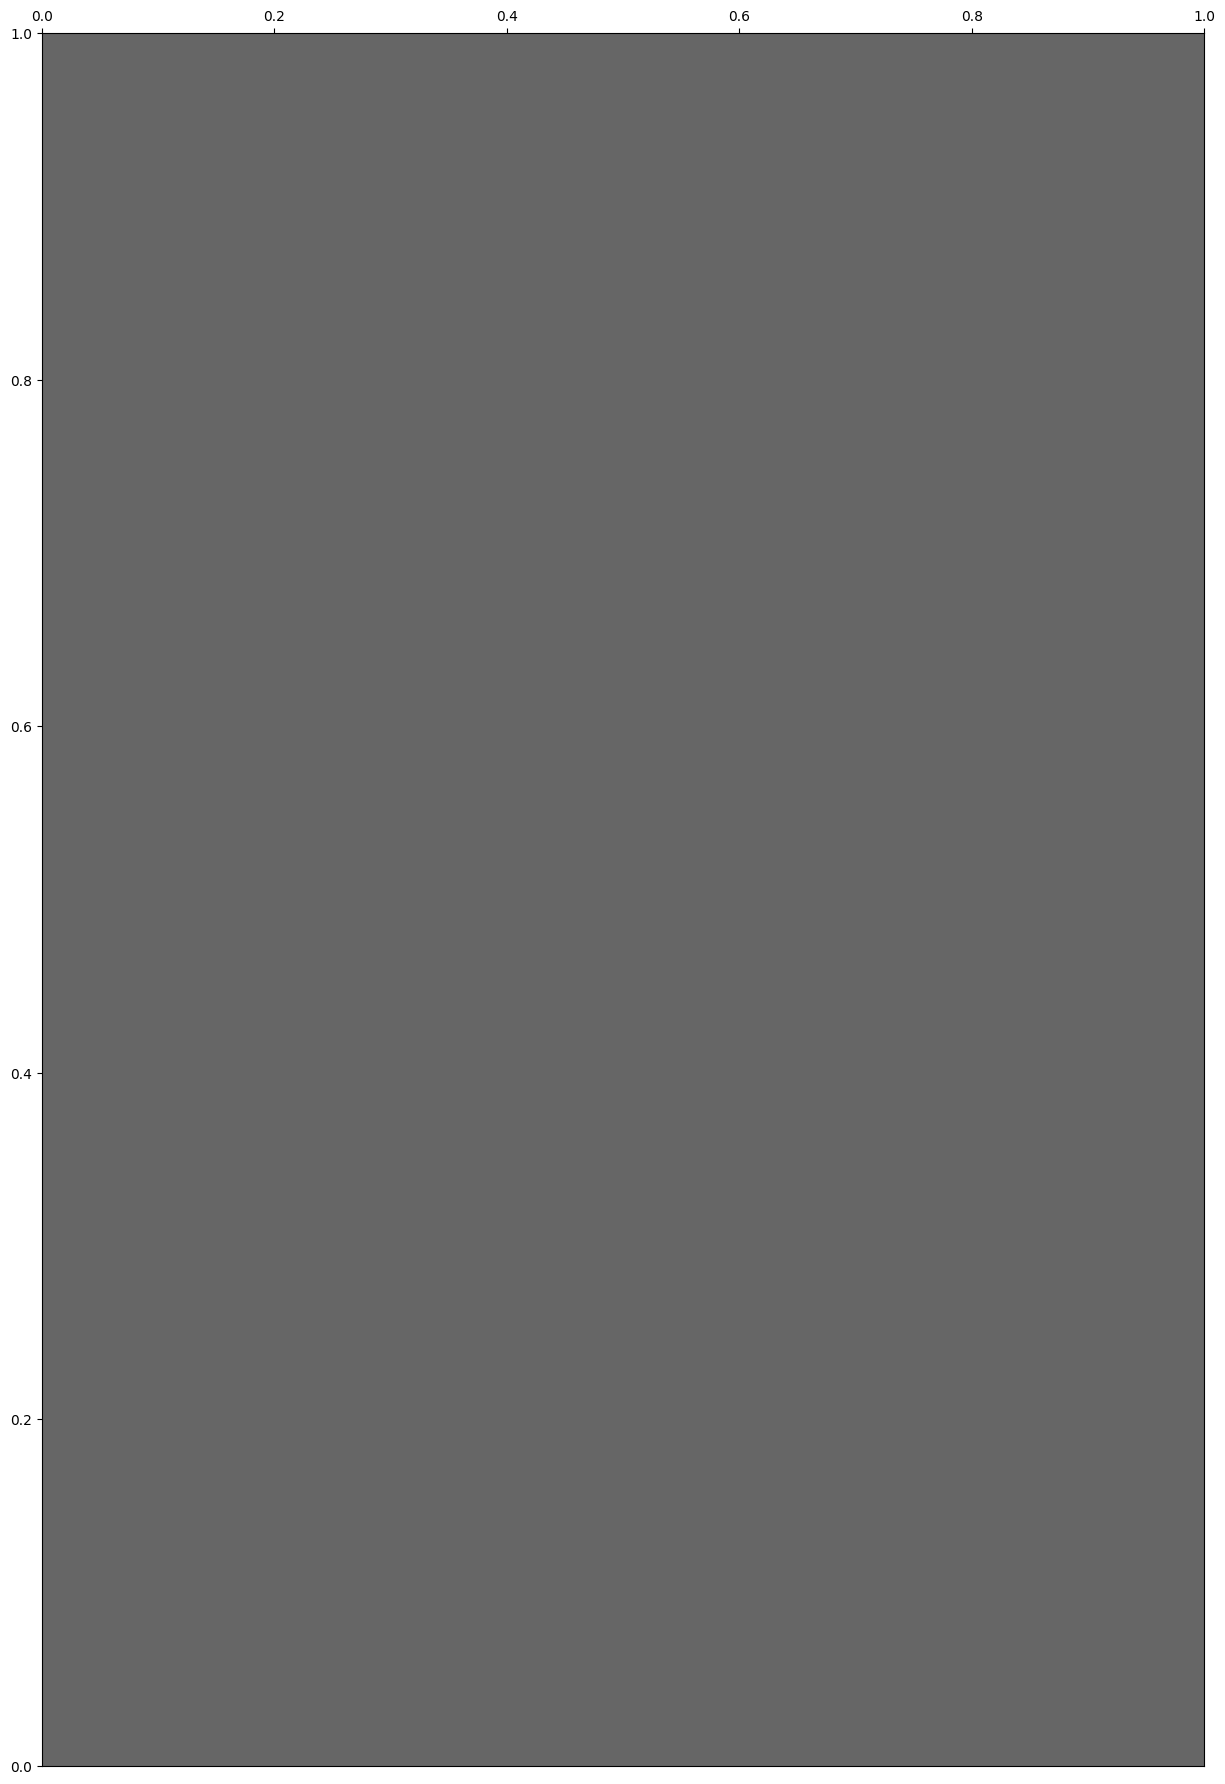

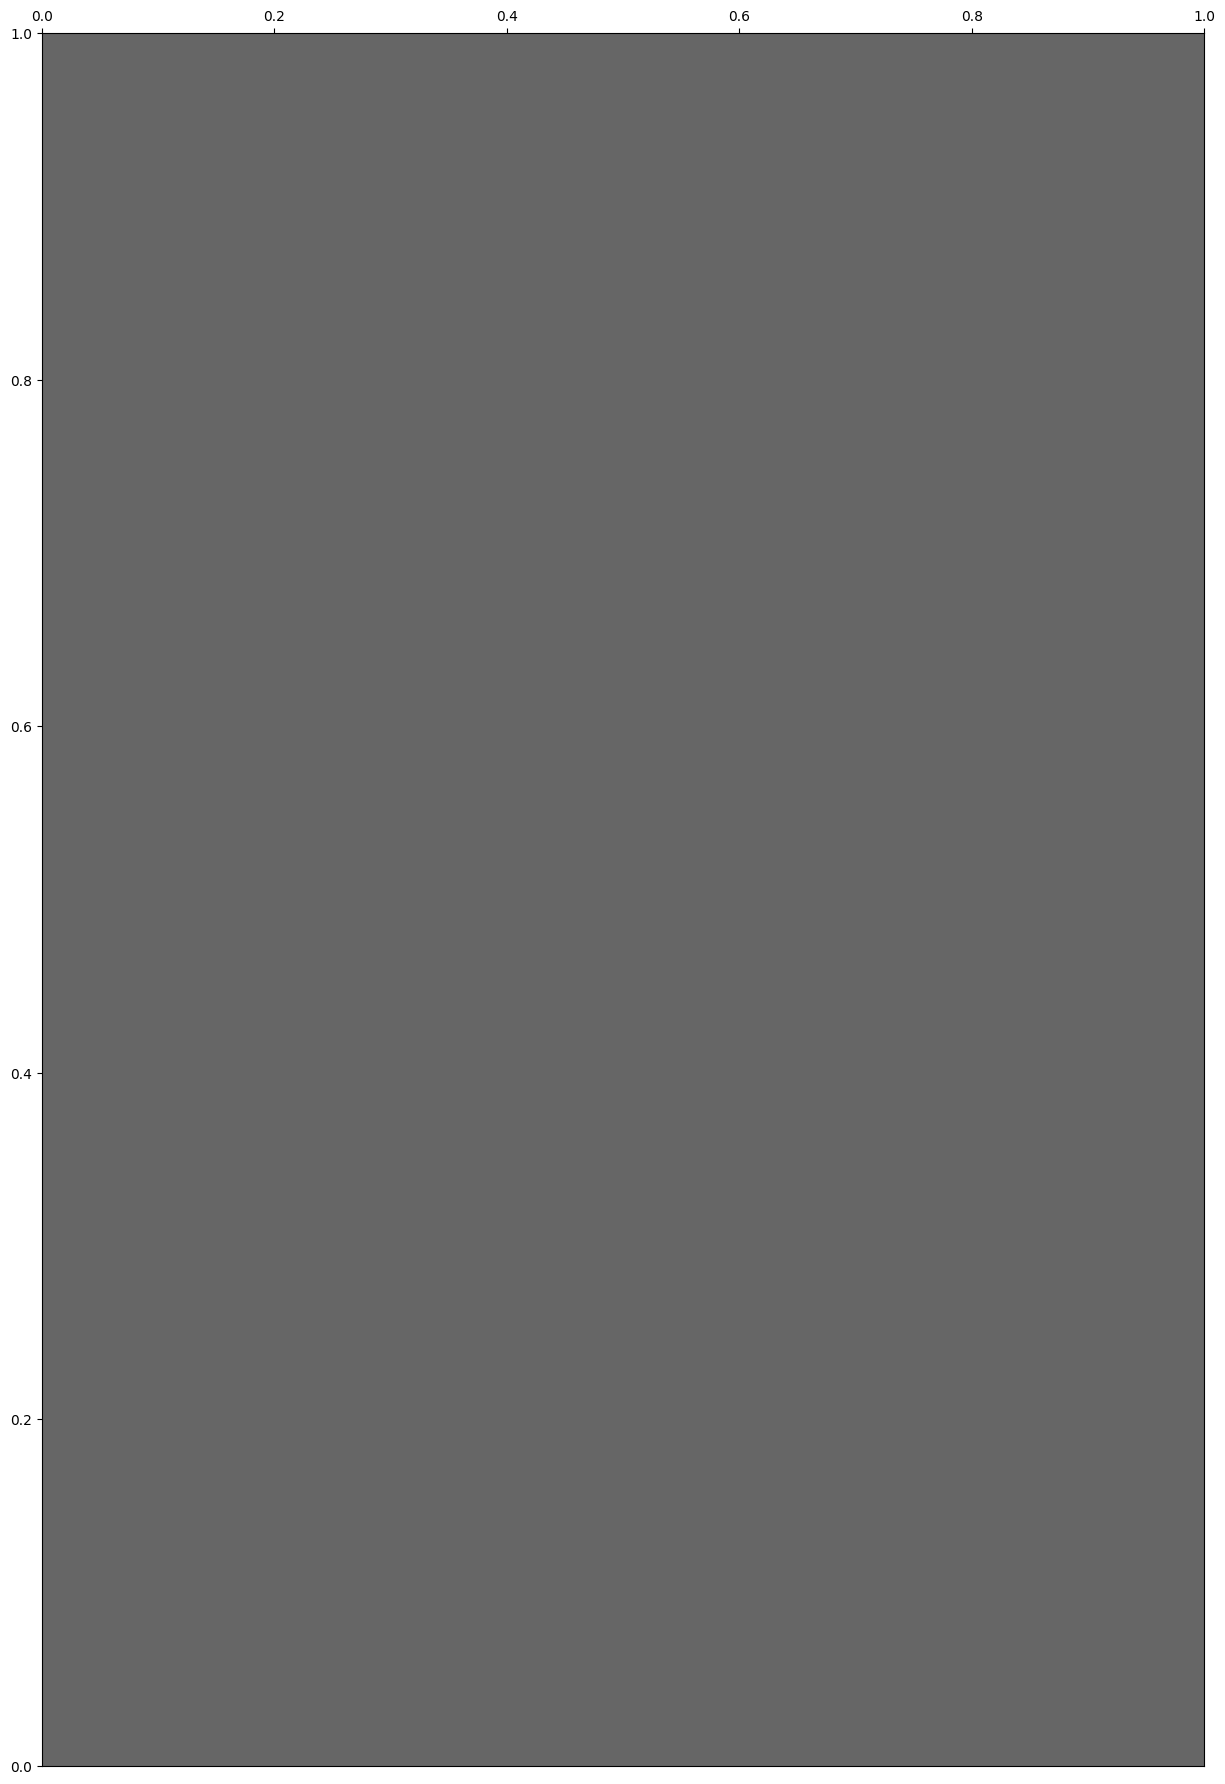

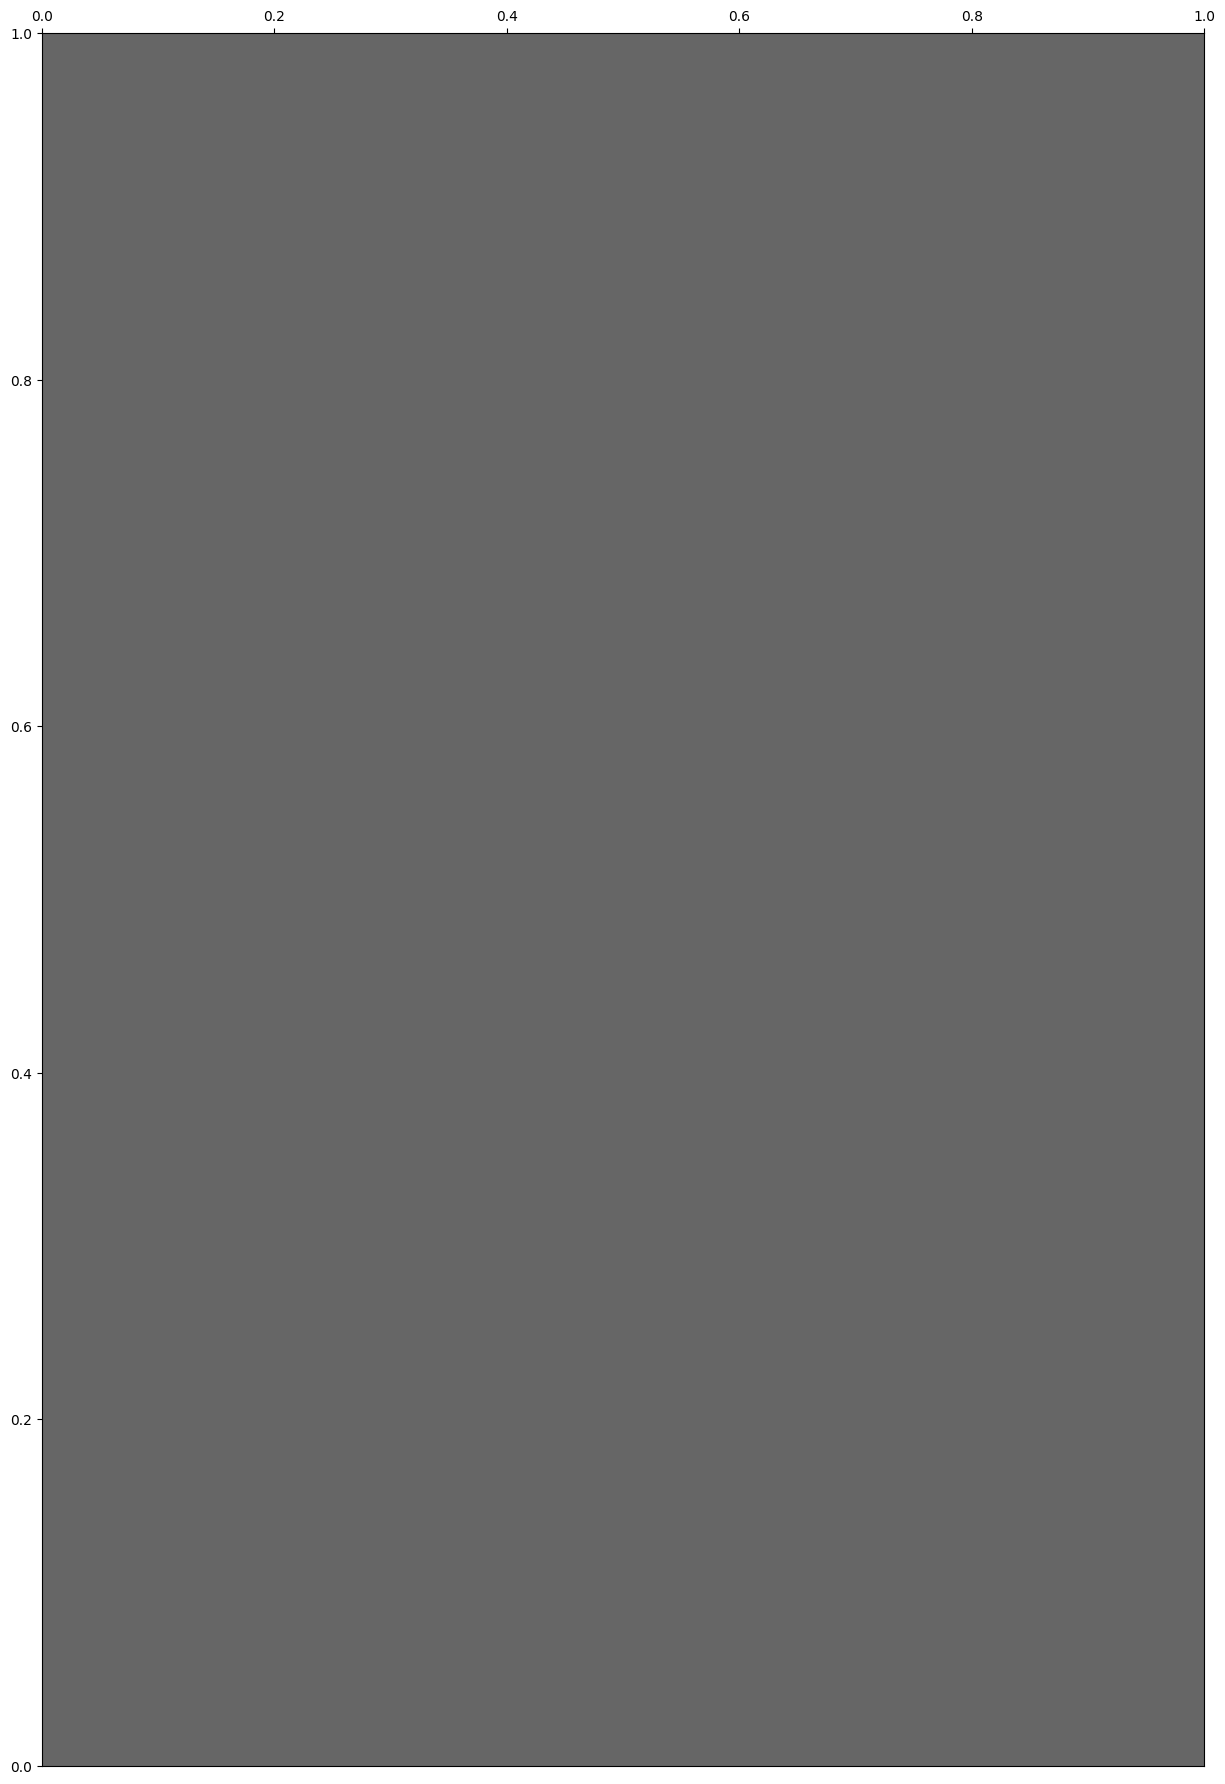

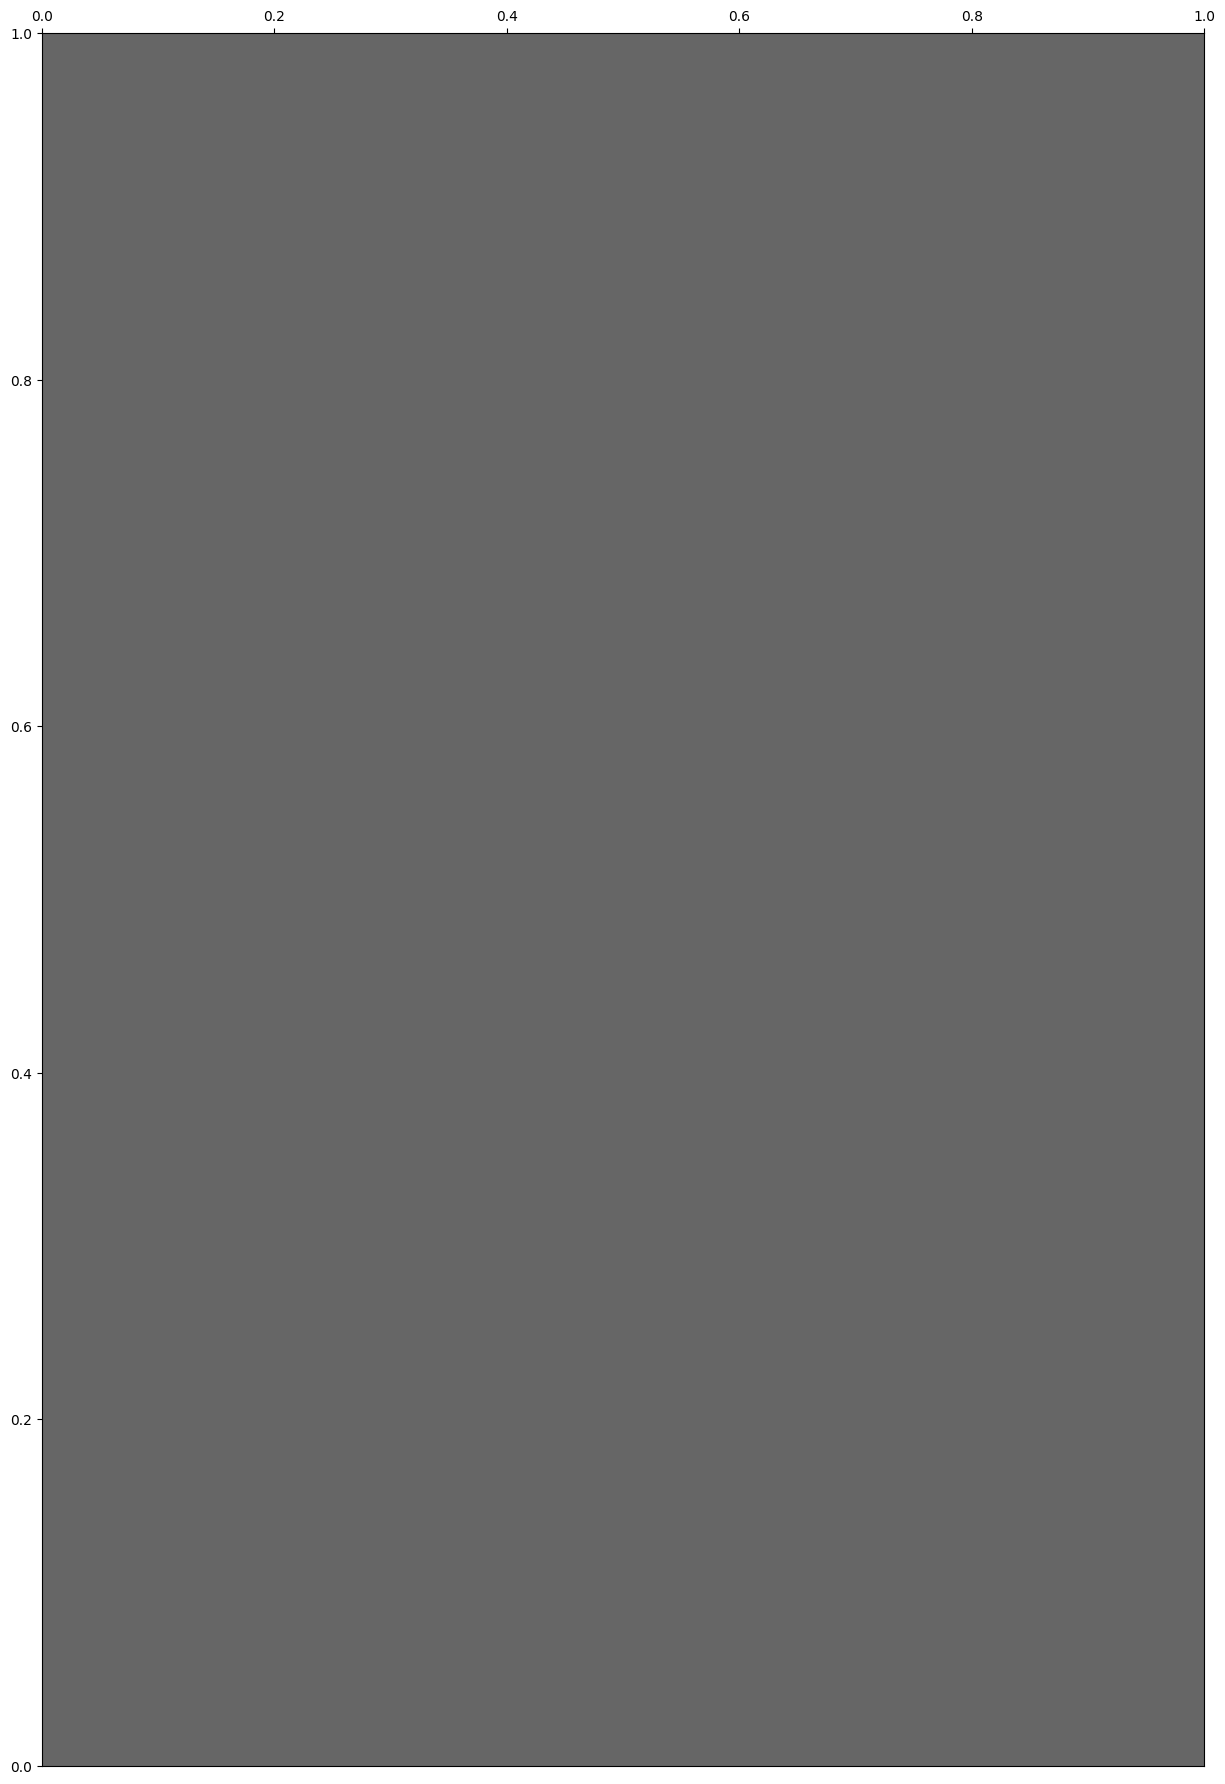

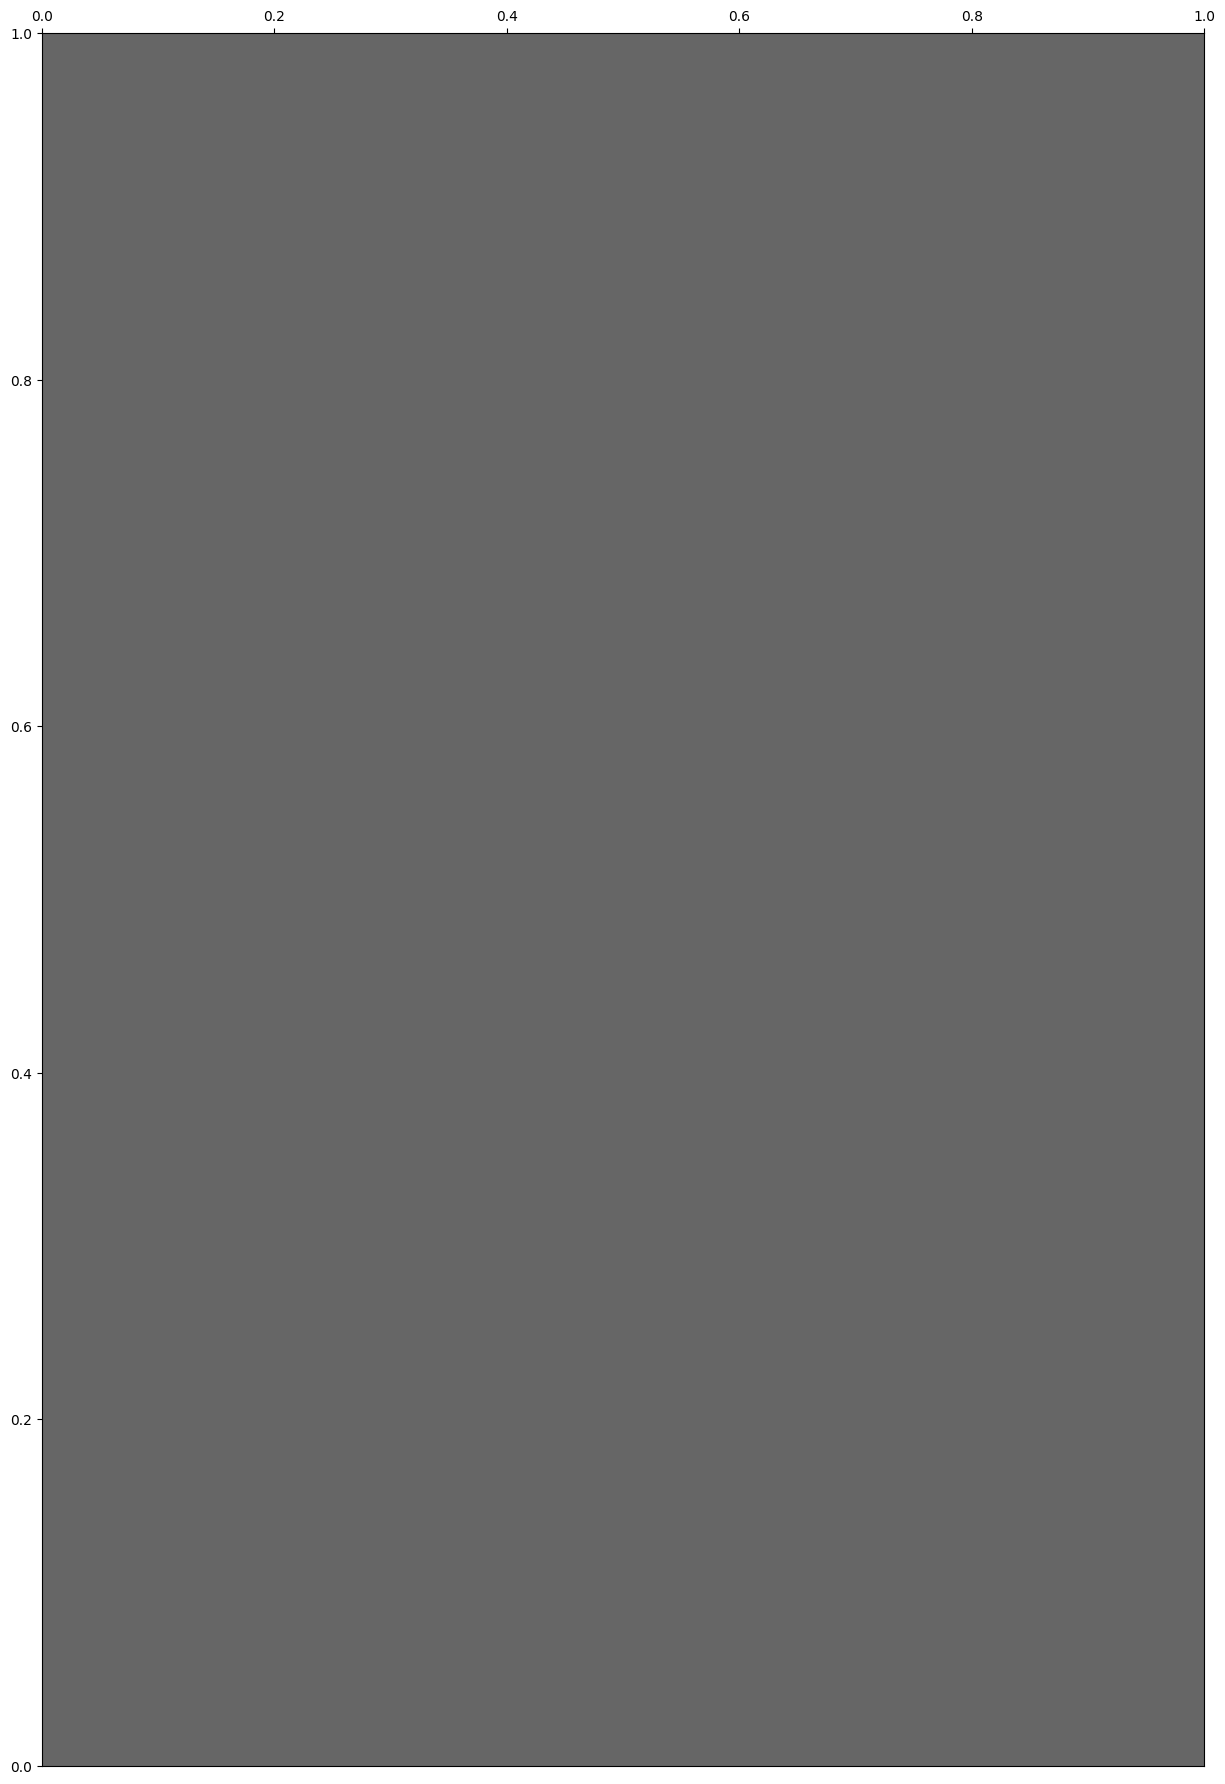

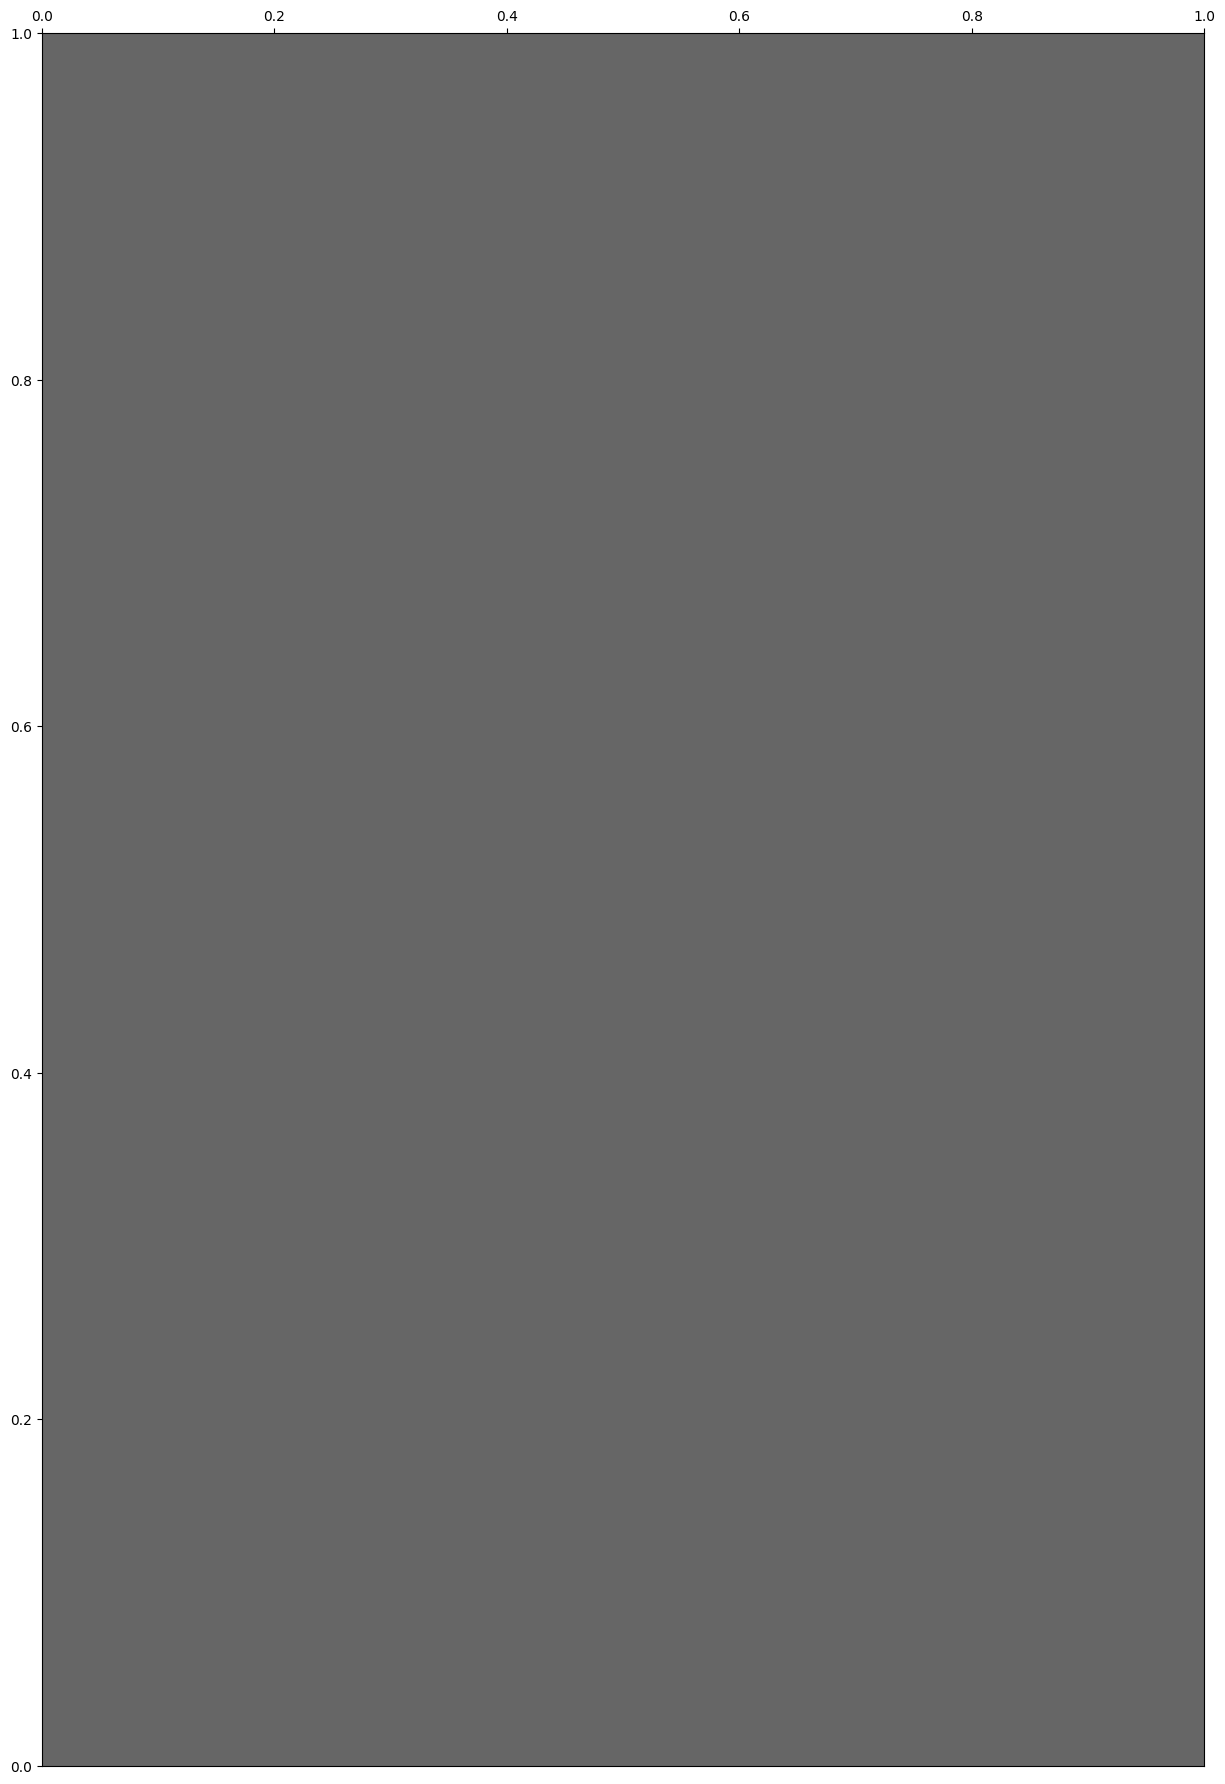

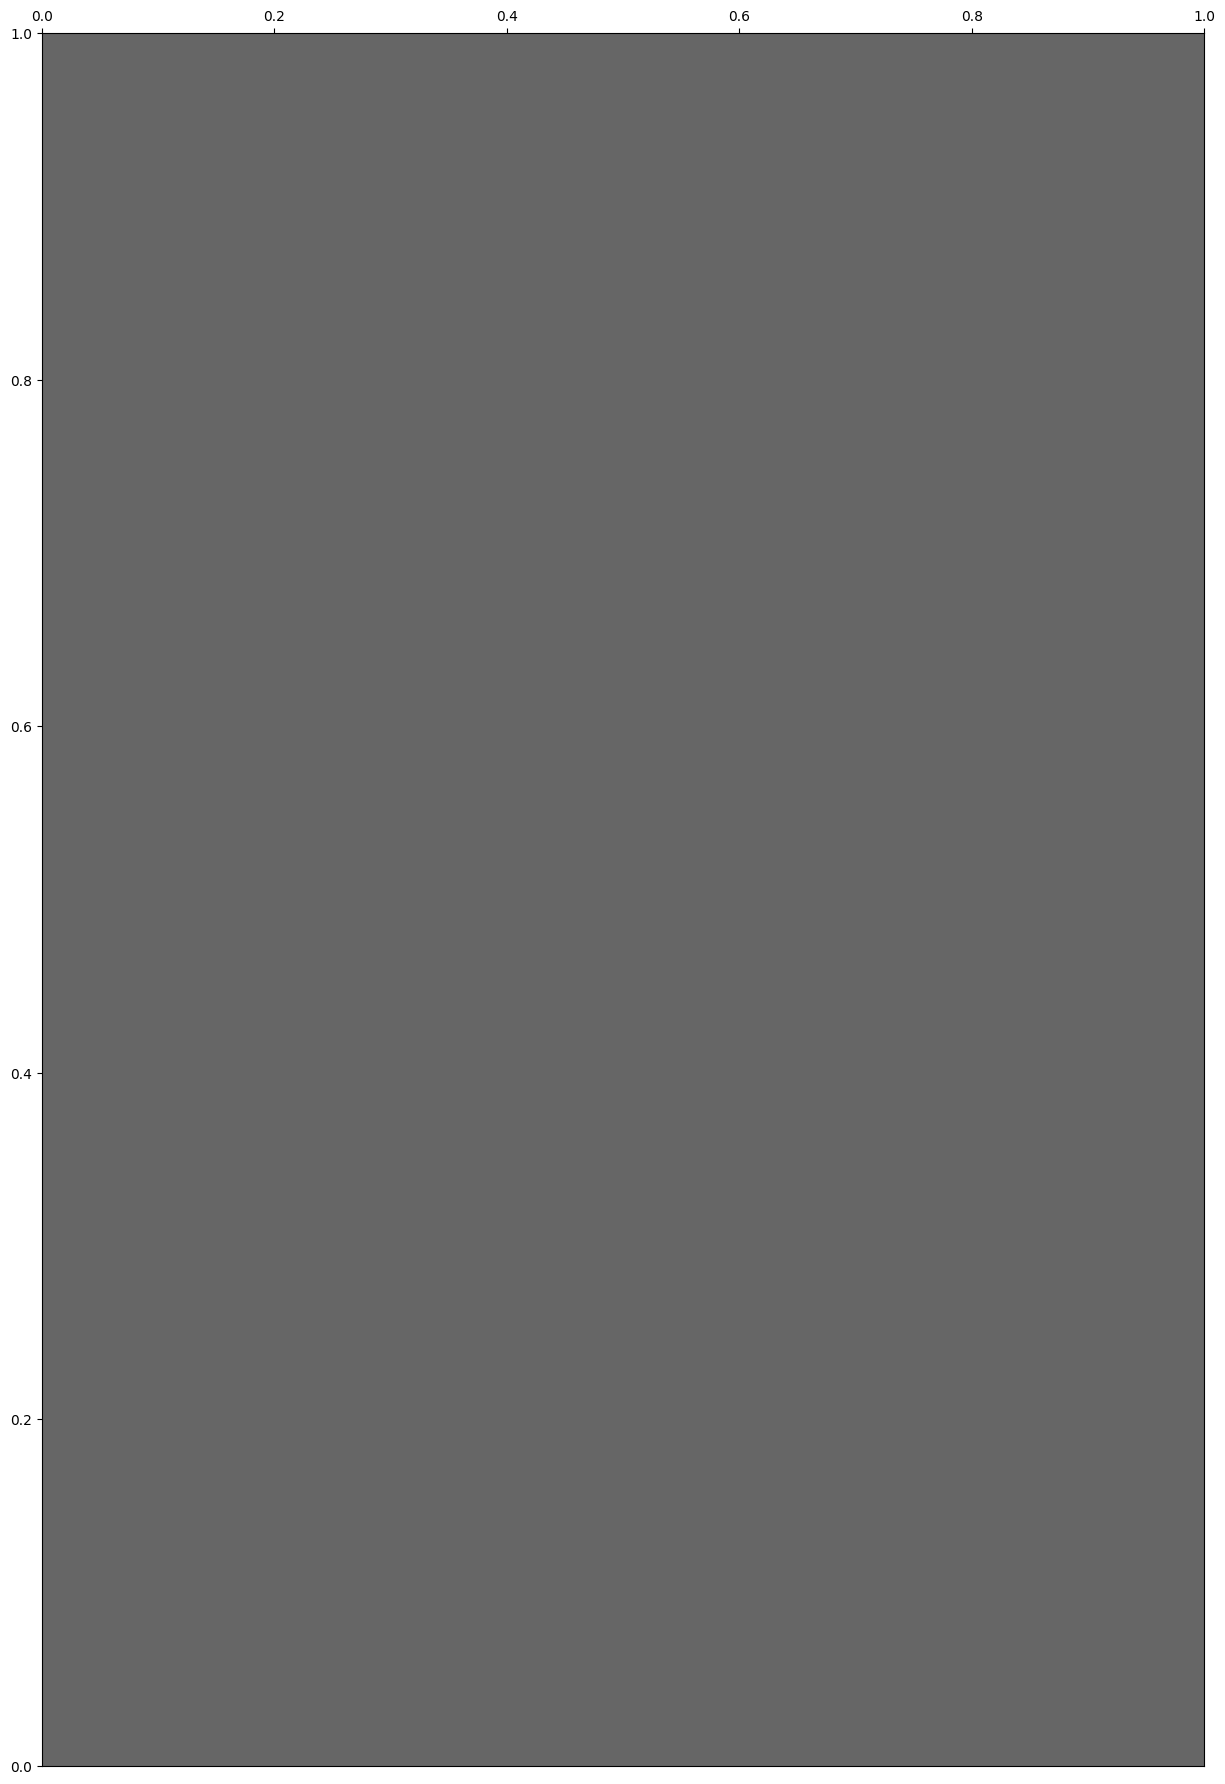

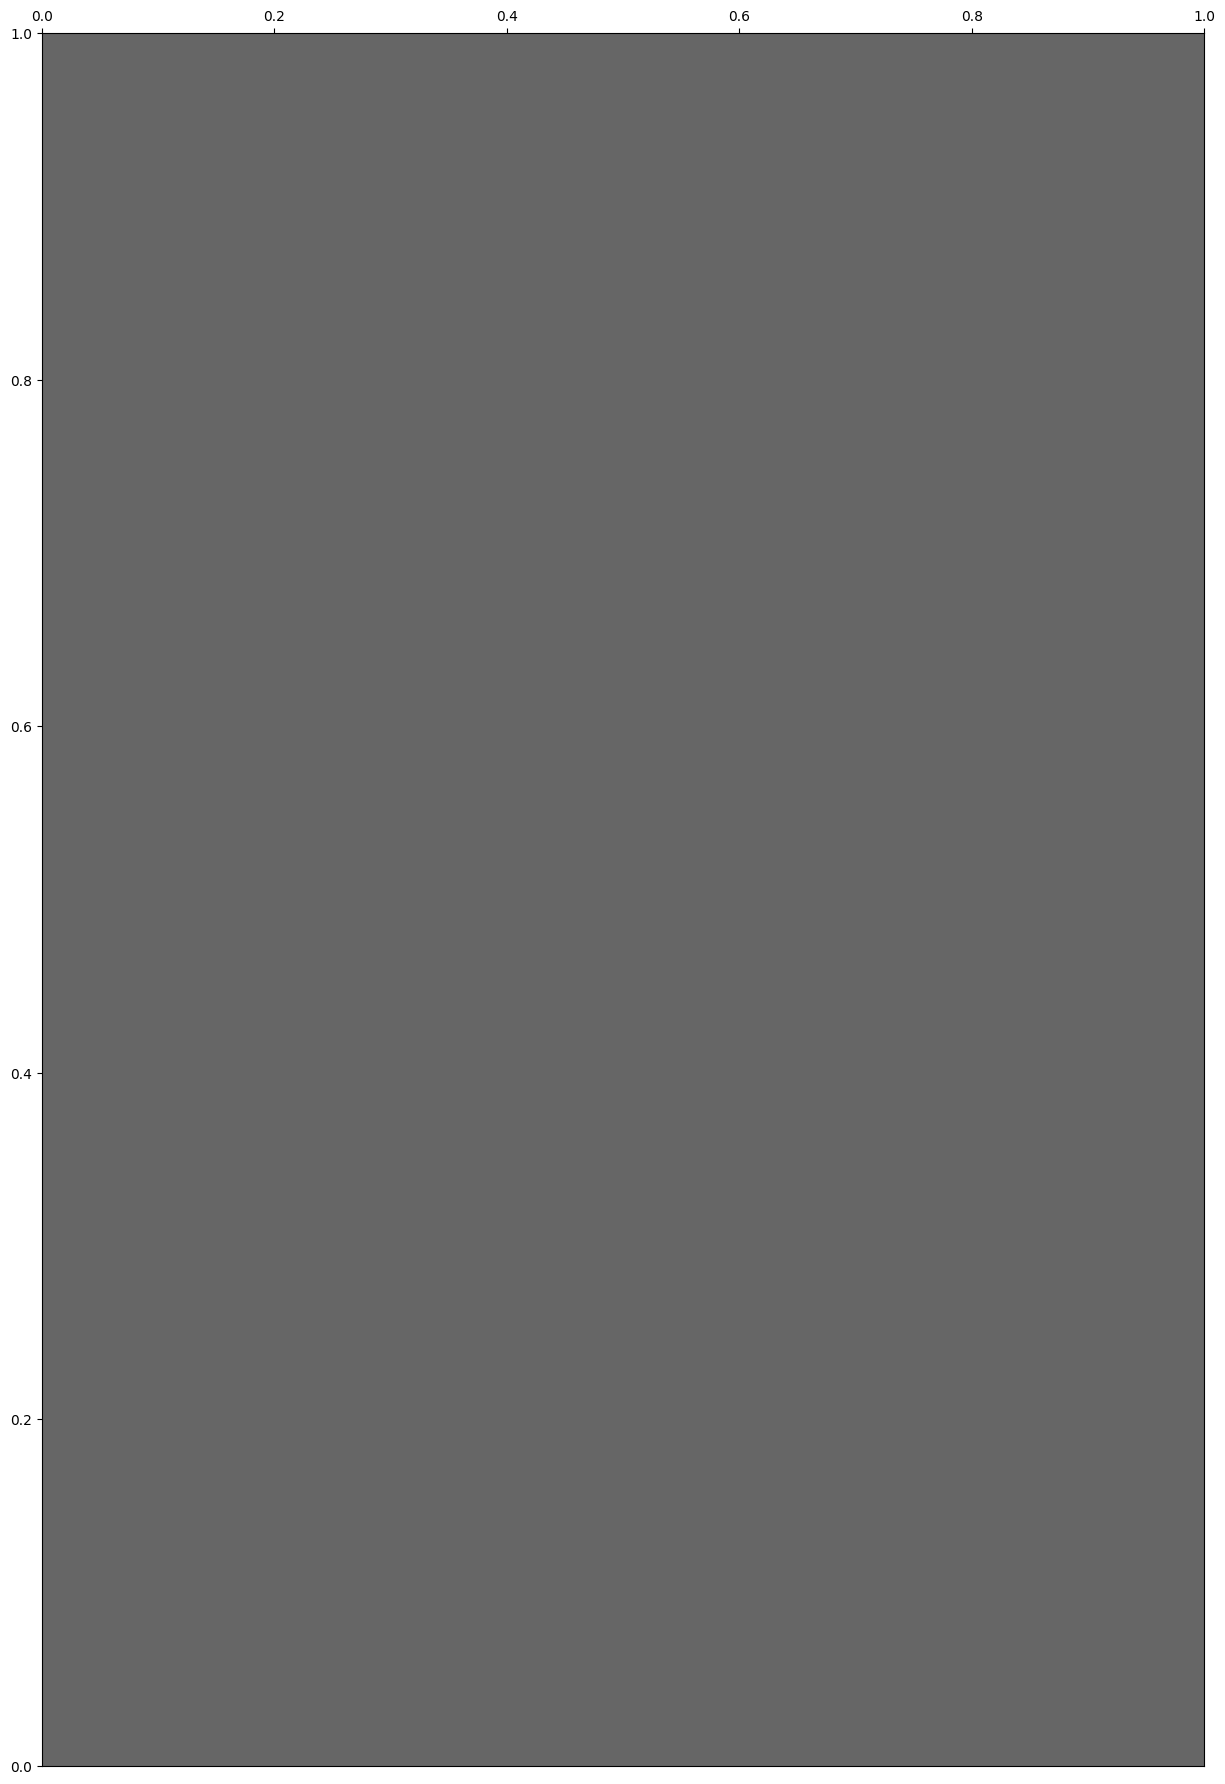

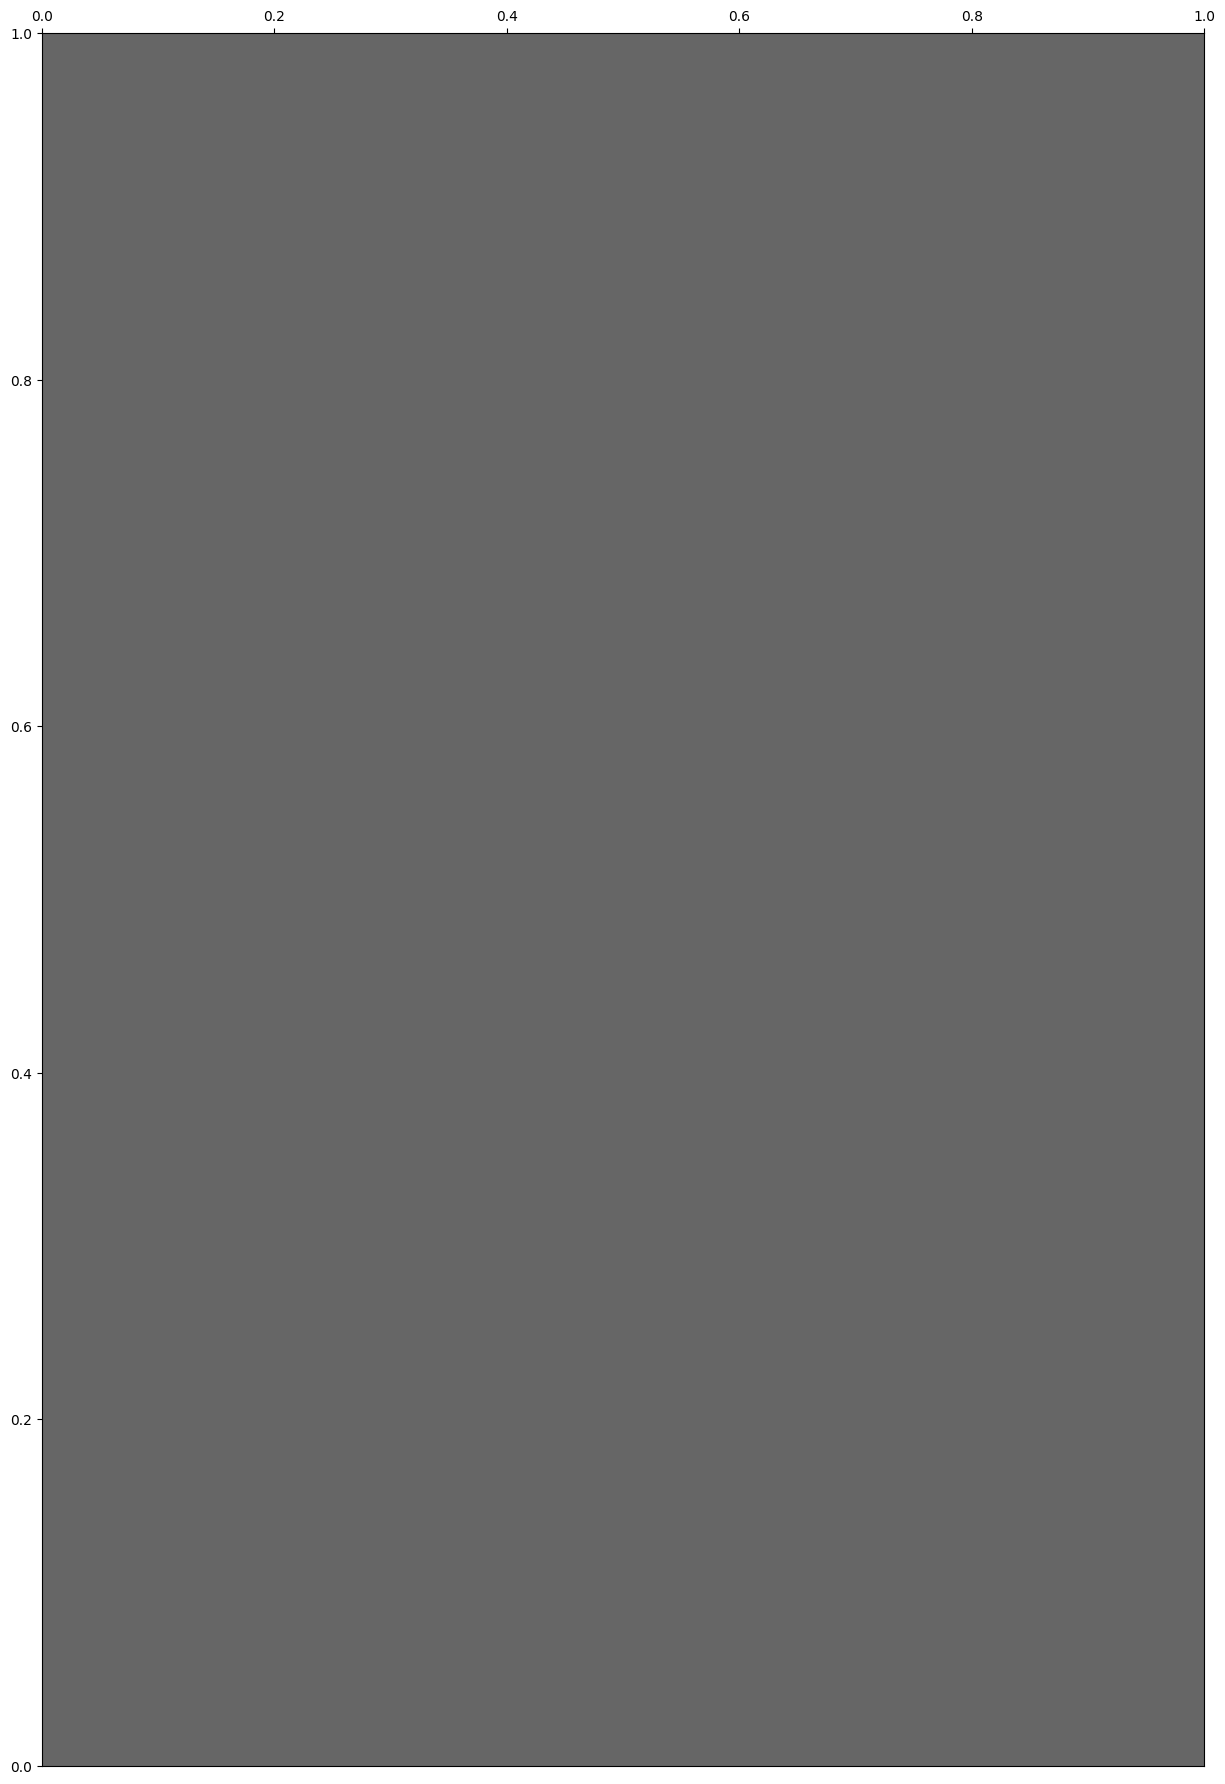

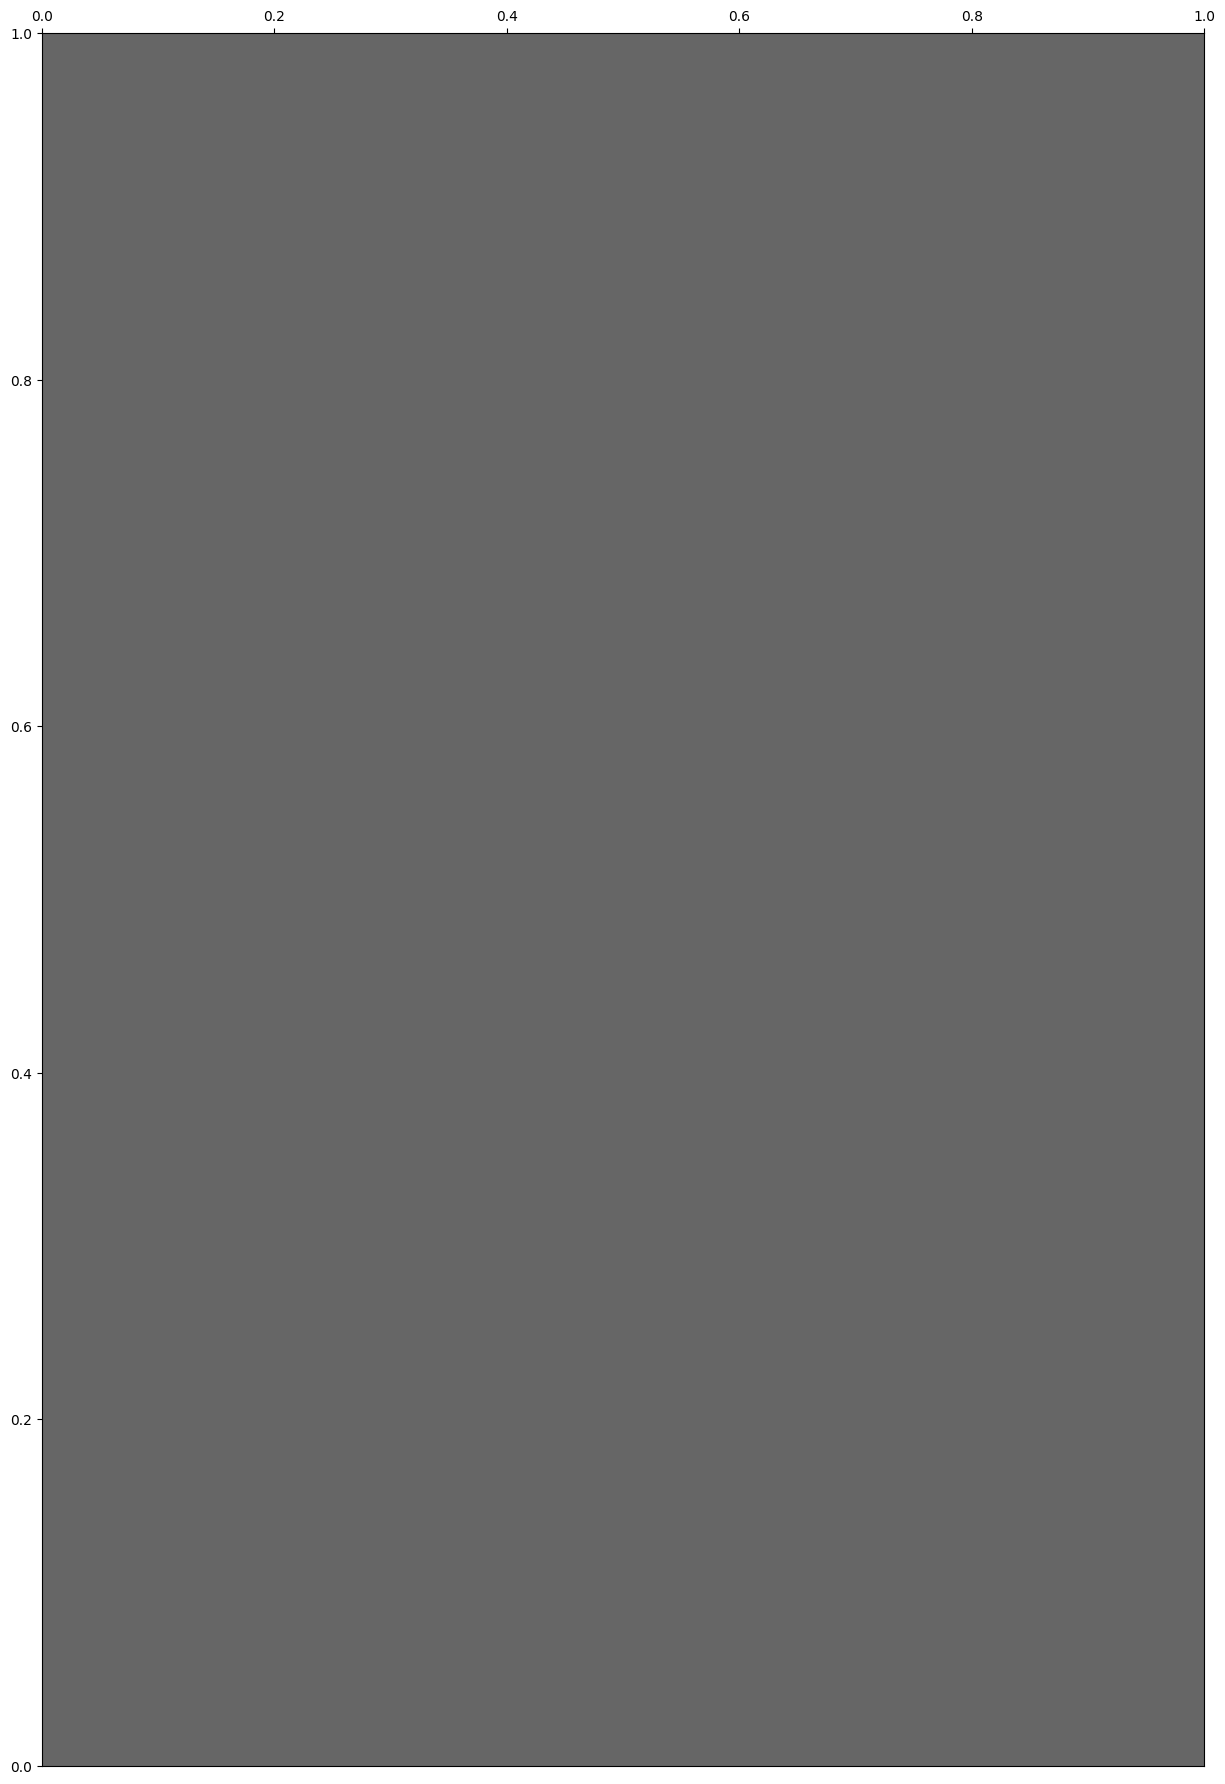

In [20]:
teamRectangles = []
driverCounter = 0
for team in teamList:
    plt.rcParams["figure.figsize"] = [15,22.5]
    fig, ax = plt.subplots()
    plt.ylim((70,0))
    ax.set_facecolor("#666666")
    title = session.event["EventName"]+" 2022 "+session.name
    driverpair = teamDict[team]
    title = team + " " + title
    for driverId in range(len(driverpair)):
        driverCounter = driverCounter+1
        #fig.set_facecolor("#"+str(session.get_driver(driverpair[driverId]).TeamColor))
        singleDriverDataFrame = lapsDataFrame[lapsDataFrame["DriverNumber"]==driverpair[driverId]]
        oldColumns = singleDriverDataFrame.columns.to_list()
        usefulColumns = ['DriverNumber','LapTime','CorrectedPitOutTime','CorrectedTime','CorrectedPitInTime','IsPersonalBest','Compound','FreshTyre','Team']
        for x in oldColumns:
            if x not in usefulColumns:
                del singleDriverDataFrame[x]

        tyreColor = []
        rectangleStart = []
        rectangleStop = []
        lapTimes = []
        for i in range(len(singleDriverDataFrame["CorrectedPitOutTime"].to_list())):
            #tyre coloring
            if singleDriverDataFrame["IsPersonalBest"].to_list()[i]:
                tyreColor.append("PersonalBest")
            else:
                tyreString = ""
                if singleDriverDataFrame["FreshTyre"].to_list()[i]:
                    tyreString = "Fresh"
                else:
                    tyreString = "Used"
                tyreString = tyreString + singleDriverDataFrame["Compound"].to_list()[i]
                tyreColor.append(tyreString)
            #start of rectangle
            if pd.isnull(singleDriverDataFrame["CorrectedPitOutTime"].to_list()[i]):
                rectangleStart.append((singleDriverDataFrame["CorrectedTime"].to_list()[i-1].seconds+singleDriverDataFrame["CorrectedTime"].to_list()[i-1].microseconds/1000000)/60)
            else:
                rectangleStart.append((singleDriverDataFrame["CorrectedPitOutTime"].to_list()[i].seconds+singleDriverDataFrame["CorrectedPitOutTime"].to_list()[i].microseconds/1000000)/60)
            #end of rectangle
            if pd.isnull(singleDriverDataFrame["CorrectedPitInTime"].to_list()[i]):
                rectangleStop.append((singleDriverDataFrame["CorrectedTime"].to_list()[i].seconds+singleDriverDataFrame["CorrectedTime"].to_list()[i].microseconds/1000000)/60)
            else:
                rectangleStop.append((singleDriverDataFrame["CorrectedPitInTime"].to_list()[i].seconds+singleDriverDataFrame["CorrectedPitInTime"].to_list()[i].microseconds/1000000)/60)
            if pd.isnull(singleDriverDataFrame["LapTime"].to_list()[i]):
                lapTimes.append("")
            else:
                if len(str(singleDriverDataFrame["LapTime"].to_list()[i].seconds%60))==2:
                    correctSeconds = str(singleDriverDataFrame["LapTime"].to_list()[i].seconds%60)
                else:
                    correctSeconds = "0"+str(singleDriverDataFrame["LapTime"].to_list()[i].seconds%60)
                lapTime = str(singleDriverDataFrame["LapTime"].to_list()[i].seconds//60)+":"+correctSeconds+"."+str(singleDriverDataFrame["LapTime"].to_list()[i].microseconds)[0:3]
                lapTimes.append(lapTime)
            #plt.bar(driverId, 70, 1, 0, color = "#"+str(session.get_driver(session.drivers[driverId])["TeamColor"].upper()), alpha = 0.5)
            for r in range(len(redFlagBeginnings)):
                end = redFlagEndings[r]
                begin = redFlagBeginnings[r]
                rect = plt.Rectangle((driverCounter-0.5,end),1,begin-end,color = "r", alpha = 0.4)
                ax.add_patch(rect)
            for x in range(len(lapTimes)):
                plt.bar(driverCounter,rectangleStop[x]-rectangleStart[x],0.75,rectangleStart[x], color=compoundColors[tyreColor[x]], edgecolor = "black")
                plt.text(driverCounter,rectangleStop[x]-(rectangleStop[x]-rectangleStart[x])/2,lapTimes[x],fontsize = 15,verticalalignment='center',horizontalalignment='center',fontfamily='Arial')
            #plt.text()
            
            
            #for x in teamRectangles:
            #    ax.add_patch(x)
            plt.title(title, font = "Arial", fontsize = 40)
            ax.xaxis.tick_top()
    plt.savefig(title+".png")
    plt.cla()
            #ax.get_xaxis().set_ticks(ticks=stupidList[0:2],values=driverTickData[0:2])


In [9]:


for driverId in range(drivernumber):
    for x in range(len(lapTimes)):
        plt.bar(driverId,rectangleStop[x]-rectangleStart[x],0.75,rectangleStart[x], data = lapTimes[x], color=compoundColors[tyreColor[x]], edgecolor = "black")
        plt.text(driverId,rectangleStop[x]-(rectangleStop[x]-rectangleStart[x])/2,lapTimes[x],verticalalignment='center',horizontalalignment='center',fontfamily='Arial')
    teamrect = plt.Rectangle((driverId-0.5,70),1,70,
    color="#"+session.get_driver(session.drivers[driverId])["TeamColor"].upper(),
    alpha = 0.5)
    color = "#"+session.get_driver(session.drivers[driverId])["TeamColor"].upper()
    teamRectangles.append(color)
    
    #for x in teamRectangles:
    #    ax.add_patch(x)
    plt.title(title, font = "Arial", fontsize = 40)
    plt.xlabel()
    ax.xaxis.tick_top()


NameError: name 'drivernumber' is not defined

In [ ]:
teamRectangles

['#1E5BC6', '#ED1C24']

In [10]:

session.get_driver('1').TeamColor

'1e5bc6'